In [95]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [96]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

In [97]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
data_all = pd.concat([train.iloc[:, :-1], test])
y = train['income']

## marital-status labeling

In [98]:
data_all['marital-status'][data_all['marital-status']!=' Married-civ-spouse'] = 0
data_all['marital-status'][data_all['marital-status']==' Married-civ-spouse'] = 1
data_all['marital-status'] = data_all['marital-status'].astype('int64')

C:\Users\bigBro\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bigBro\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## relationship labeling

In [99]:
data_all['relationship'][(data_all['relationship']!=' Husband') & (data_all['relationship']!=' Wife')] = 0
data_all['relationship'][(data_all['relationship']==' Husband') | (data_all['relationship']==' Wife')] = 1
data_all['relationship'] = data_all['relationship'].astype('int64')

C:\Users\bigBro\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bigBro\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## drop un-important column

In [100]:
del data_all['education']
#del data_all['native-country']
#del data_all['workclass']
del data_all['no']
#del data_all['race']
del data_all['fnlwgt']

## One-Hot Encoding

In [101]:
one_hot_encoding = pd.get_dummies(data_all)
one_hot_encoding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 19536
Data columns (total 80 columns):
age                                           48842 non-null int64
education-num                                 48842 non-null int64
marital-status                                48842 non-null int64
relationship                                  48842 non-null int64
capital-gain                                  48842 non-null int64
capital-loss                                  48842 non-null int64
hours-per-week                                48842 non-null int64
workclass_ ?                                  48842 non-null uint8
workclass_ Federal-gov                        48842 non-null uint8
workclass_ Local-gov                          48842 non-null uint8
workclass_ Never-worked                       48842 non-null uint8
workclass_ Private                            48842 non-null uint8
workclass_ Self-emp-inc                       48842 non-null uint8
workclass_ Self-emp-

## Train/Test Data Split

In [102]:
X = one_hot_encoding[:len(train)]
X_test = one_hot_encoding[len(train):]

## Scaling

In [103]:
sc = MinMaxScaler()
sc.fit(one_hot_encoding)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [104]:
X_tr = sc.transform(X)
X_te = sc.transform(X_test)

## LightGBM

In [105]:
from lightgbm import LGBMClassifier

In [112]:
model_lgbm = LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.15, 0.20],
    'max_depth': [5, 6, 7],
    'num_leaves': [31, 63, 127],
    'reg_alpha': [0.05 ,0.1, 0.15],
    'reg_lambda': [0, 0.1],
    'min_child_samples': [0, 3, 6],
    'min_data_in_leaf': [45, 55],
    'n_estimators':[195, 225]
    }
cv=KFold(n_splits=6, random_state=1)
gcv=GridSearchCV(model_lgbm, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

gcv.fit(X_tr, y)

GridSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=N...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.15, 0.2],
                         'max_depth': [5, 6, 7], 'min_child_samples': [0, 3, 6],
                        

In [107]:
model_lgbm = gcv.best_estimator_
gcv.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.15, max_depth=6,
               min_child_samples=0, min_child_weight=0.001, min_data_in_leaf=45,
               min_split_gain=0.0, n_estimators=195, n_jobs=-1, num_leaves=63,
               objective=None, random_state=None, reg_alpha=0.1, reg_lambda=0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [108]:
cross_val_score(model_lgbm, X_tr, y).mean()

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8707046191819453

## to_csv

In [109]:
y_pred = model_lgbm.predict(X_te)
y_pred = (y_pred > 0.5)
y_pred = pd.DataFrame(y_pred, columns=['income'])
y_pred.iloc[:, 0].value_counts()

False    15562
True      3975
Name: income, dtype: int64

In [110]:
y_pred['income'].replace(True, 1, inplace=True)
y_pred['income'].replace(False, 0, inplace=True)
y_pred = y_pred.astype('int64')

In [111]:
result = pd.concat([pd.DataFrame(test['no'].values, columns=['no']), y_pred], axis=1)
result.to_csv('./submission.csv', index=False)

## Public Leaderboard Score
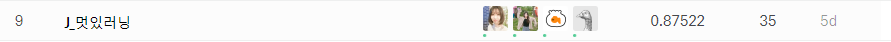

## Private Leaderboard Score
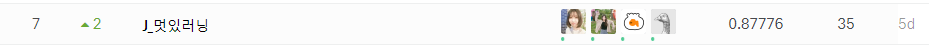